In [57]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.misc
import skimage.segmentation
import skimage.feature
from copy import copy
import imageio

In [58]:
# Location of the PASCAL VOC data

img_dir = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages"

In [59]:
### Create initial regions by Felzenszwalb’s efficient graph based segmentaion algorithm

In [60]:
# Lets try it  out and visualize the segmented images. The followng codes randomly selects 5 frames
# from PASCAL data and visualize its original images and segmented image

Total images in the directory : (17125,)
Random image path shape is : (5,)


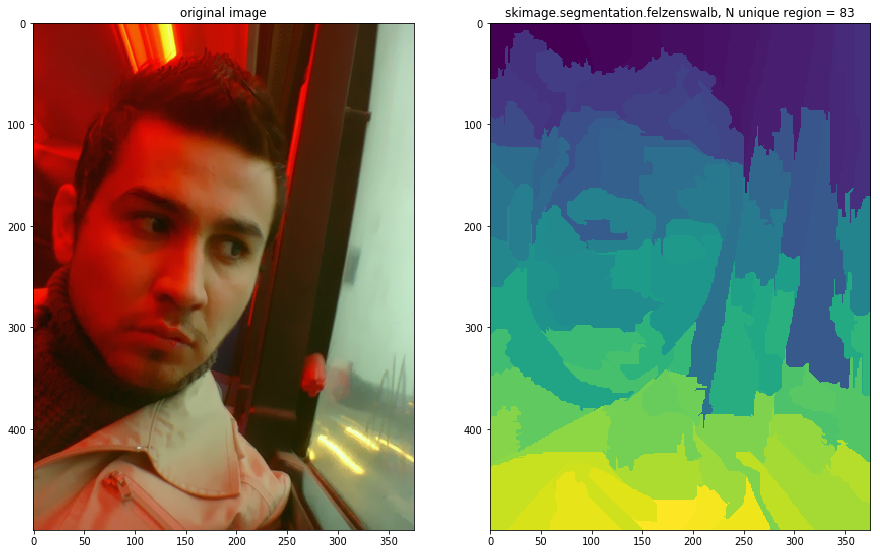

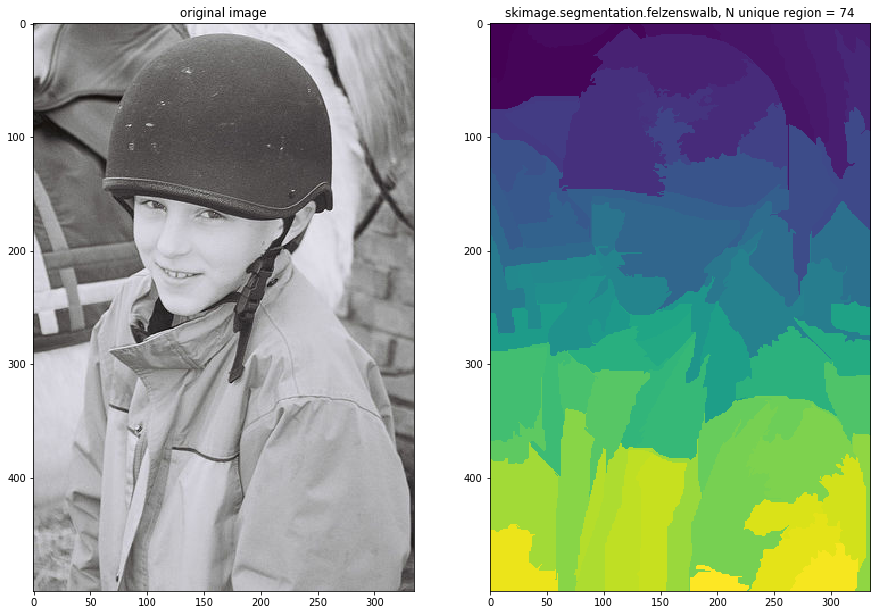

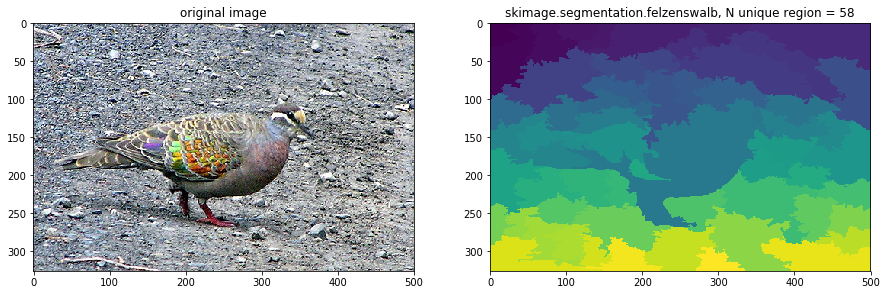

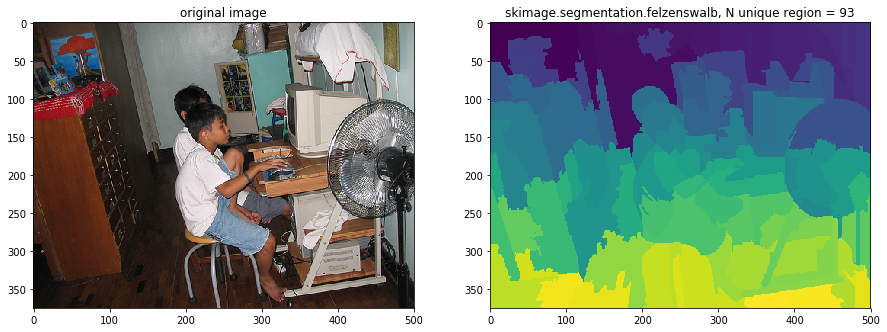

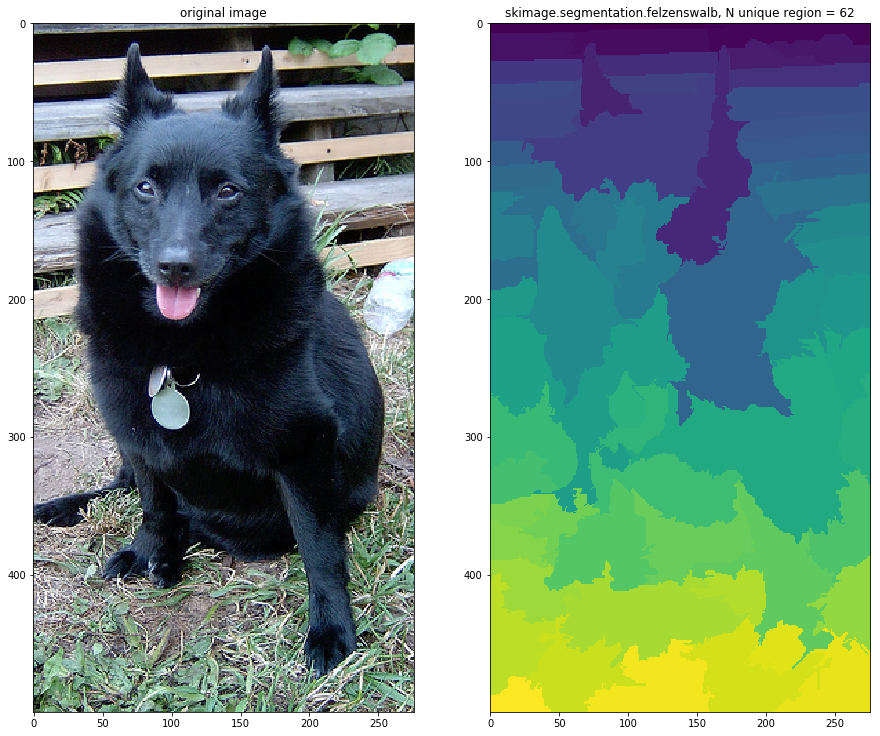

In [61]:
def image_segmentation(img_8bit, scale = 1.0, sigma =0.8, min_size = 50):
    '''
    J.R.R. Uijlings's hierarchical grouping algorithm 
    
    == input ==
    img_8bit : shape = (height, width, 3),
               8-bits degital image (each digit ranges between 0 - 255)
    
    == output ==
    img      : shape = (height, width, 4)
    '''
    
    # convert the image to range between 0 and 1
    img_float = skimage.util.img_as_float(img_8bit)
    im_mask = skimage.segmentation.felzenszwalb(img_float, scale = scale, sigma= sigma, min_size = min_size)
    img = np.dstack([img_8bit, im_mask])
    return img

scale = 1.0
sigma = 0.8
#min_size may be around 50 for better RCNN performance but for the sake of visualization, we take min_size = 500





min_size = 500

np.random.seed(4)
listed_path = os.listdir(img_dir)
print("Total images in the directory : {}".format(np.shape(listed_path)))
Nplot = 5

random_img_path = np.random.choice(listed_path, Nplot)
print("Random image path shape is : {}".format(random_img_path.shape))

for img_name in random_img_path:
    img_8bit = imageio.imread(os.path.join(img_dir, img_name))
    img = image_segmentation(img_8bit, scale, sigma, min_size)
    
    fig = plt.figure(figsize = (15, 30))
    ax  = fig.add_subplot(1, 2, 1)
    ax.imshow(img_8bit)
    
    ax.set_title("original image")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(img[:,:, 3])
    ax.set_title("skimage.segmentation.felzenswalb, N unique region = {}".format(len(np.unique(img[:,:,3]))))

    plt.show()







In [62]:
def extract_region(img):
    '''
    For each segmented region,
    extract smallest rectangle regions covering the smallest segmented region.
    
    == input ==
    img : (height, width, N channel)
          N channel = [R, G, B , L], L = label for the region
          only the L channel is used in this analysis 
    == output ==
    
    dictionary R :
    
    {0: {'labels': [0], 'max_x': 131, 'max_y': 74, 'min_x': 0,   'min_y': 0},
     1: {'labels': [1], 'max_x': 189, 'max_y': 37, 'min_x': 75,  'min_y': 0},
     2: {'labels': [2], 'max_x': 282, 'max_y': 38, 'min_x': 162, 'min_y': 0},
     3: {'labels': [3], 'max_x': 499, 'max_y': 23, 'min_x': 247, 'min_y': 0},
     4: {'labels': [4], 'max_x': 499, 'max_y': 74, 'min_x': 428, 'min_y': 13},
     5: {'labels': [5], 'max_x': 441, 'max_y': 76, 'min_x': 333, 'min_y': 16},
     6: {'labels': [6], 'max_x': 348, 'max_y': 80, 'min_x': 62,  'min_y': 21},
    '''
    
    img_segment= img[:,:,3]
    R = {}
    for y, i in enumerate(img_segment):    ## along vertical axis
        for x, l in enumerate(i):          ## Along horizontal axis
            # initiate the new region
            if l not in R:
                R[l] = {"min_x" : np.Inf,
                        "min_y" : np.Inf,
                        "max_x" : 0,
                        "max_y" : 0, 
                        "labels": [1]}
                
                #bounding box
                if R[l]["min_x"] > x:
                    R[l]["min_x"] = x
                if R[l]["min_y"] > y:
                    R[l]["min_y"] = y
                if R[l]["max_x"] < x:
                    R[l]["max_x"] = x
                if R[l]["max_x"] < y:
                    R[l]["max_x"] = y
                    
    
    ## Remove region if it does not have positive height or positive width
    
    Rcopy = copy(R)
    for key in R.keys():
        r= R[key]
        if(r["min_x"] == r["max_x"]) or (r["min_y"] == r["max_y"]):
            del Rcopy[key]
    return (Rcopy)
    
R = extract_region(img)
print("{} rectangle regions are found".format(len(R)))

    

36 rectangle regions are found


In [63]:
### Visualize the initial rectangle regions from the segmentation method of Felzenswalb and Huttenlocher



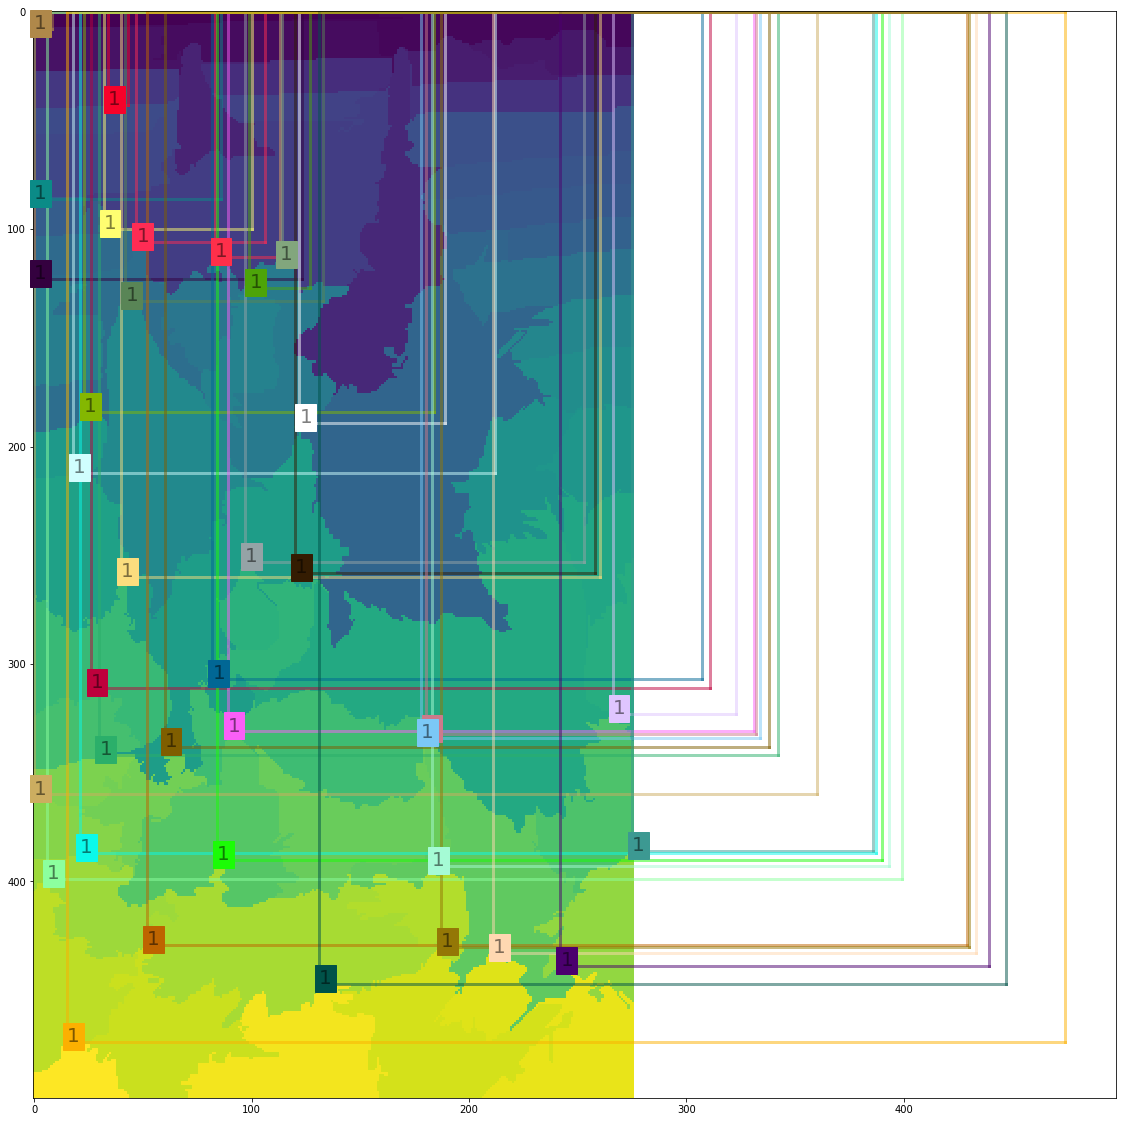

In [64]:
def plt_rectangle(plt,label, x1, y1, x2, y2, color = "yellow", alpha = 0.5):
    linewidth = 3
    if type(label) == list:
        linewidth = len(label)*3 + 2
        label = ""
        
    plt.text(x1, y1, label, fontsize = 20, backgroundcolor = color, alpha = alpha)
    plt.plot([x1, x1], [y1, y2], linewidth= linewidth, color = color, alpha  = alpha)
    plt.plot([x2, x2], [y1, y2], linewidth= linewidth, color = color, alpha  = alpha)
    plt.plot([x1, x2], [y1, y1], linewidth= linewidth, color = color, alpha  = alpha)
    plt.plot([x1, x2], [y2, y2], linewidth= linewidth, color = color, alpha  = alpha)
    
figsize = (20,20)
plt.figure(figsize = figsize)
plt.imshow(img[:,:,3]/ 2**8)

for item, color in zip(R.values(), sns.xkcd_rgb.values()):
    #print(R.values)
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    #print(label)
    plt_rectangle(plt, label, x1, y1, x2, y2, color = color)
plt.show()
    

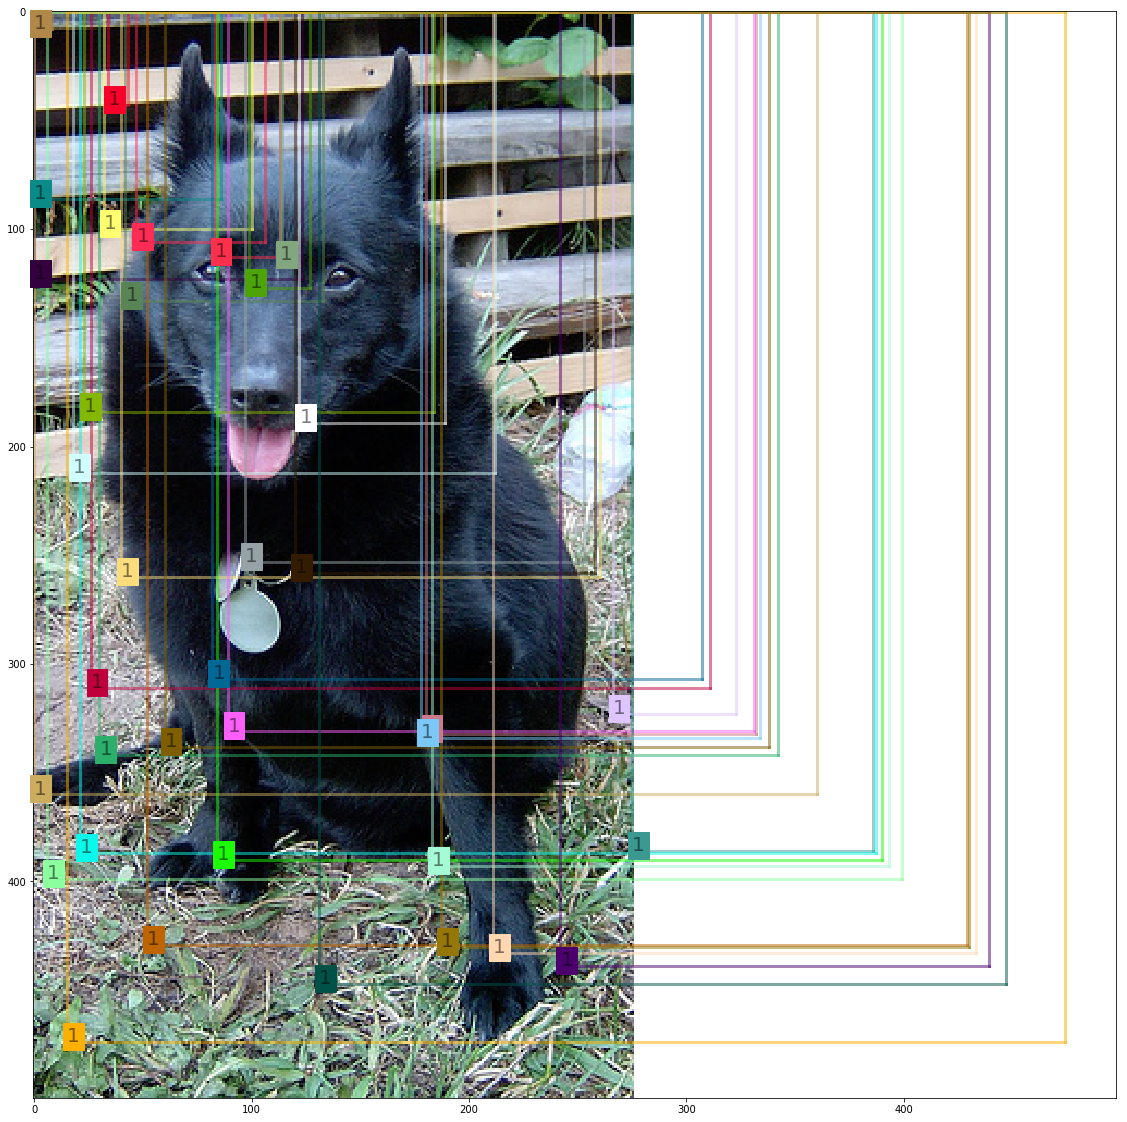

In [65]:

plt.figure(figsize=figsize)    
plt.imshow(img_8bit)
    
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

In [ ]:
_